In [1]:
from src.all_functions import *
from src.communities.communities import *

In [2]:
import _pickle as pickle
#Python Libraries for Mongos Database
import pymongo
from pymongo import MongoClient

In [3]:
from collections import Counter, defaultdict
import itertools
import operator

In [4]:
import networkx as nx
import pandas as pd
pd.set_option('display.max_rows', 100)

In [5]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Recipe Puppy API

In [6]:
pickle_in = open("./data/pandas/flavorDB_pandas.pickle","rb")

#Getting the dictionary from the pickle
flavorDB = pickle.load(pickle_in)

In [7]:
pickle_in = open("./data/pandas/mongodb_recipe_puppy_pandas","rb")

#Getting the dictionary from the pickle
recipe_puppy_api = pickle.load(pickle_in)

In [8]:
recipe_puppy_api.drop_duplicates(subset="recipe_name")

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
0,5caa762213218a112b0b979f,"[dashi, egg, egg noodles, mushroom, salt, seas...",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg
1,5caa762213218a112b0b97a0,"[egg, water]",http://www.recipezaar.com/Egg-Peeling-for-Egg-...,Egg Peeling for Egg Salad,egg
2,5caa762213218a112b0b97a1,"[black pepper, celery, cucumber, curry powder,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg
3,5caa762213218a112b0b97a2,"[baking powder, butter, egg, green onion, rame...",http://www.recipezaar.com/Ramen-Noodle-Egg-Foo...,Ramen Noodle Egg Foo Yung,egg
4,5caa762213218a112b0b97a3,"[bacon, black pepper, cheese, egg, salt]",http://www.recipezaar.com/Bacon-and-Egg-Cups-1...,Bacon and Egg Cups,egg
5,5caa762213218a112b0b97a4,"[celery, dijon mustard, egg, mayonnaise, papri...",http://www.recipezaar.com/Egg-Salad-Sandwich-D...,Egg Salad Sandwich (Diabetic),egg
6,5caa762213218a112b0b97a5,"[bread, egg, nonstick cooking spray]",http://www.recipezaar.com/Joleans-Sick-Egg-Rec...,"Jolean's "" Sick Egg"" Recipe",egg
7,5caa762213218a112b0b97a6,"[bread, chipotle pepper, egg, ranch dressing]",http://www.recipezaar.com/Greaneyes-Chipotle-T...,Greaneyes Chipotle Tabasco Egg Sandwich,egg
8,5caa762213218a112b0b97a7,"[butter, egg, ground beef, onions, sweet pepper]",http://www.recipezaar.com/Dr-Kims-Egg-Roll-211044,Dr. Kim's Egg Roll,egg
9,5caa762213218a112b0b97a8,"[egg, green onion, milk, salt, tortilla]",http://www.recipezaar.com/Easy-Egg-Wraps-77991,Easy Egg Wraps,egg


In [9]:
searched_ingredient_list = flavorDB["ingredient"].tolist()

In [10]:
print("Total number of ingredients searched: ", len(searched_ingredient_list))

Total number of ingredients searched:  619


# Filtering out recipes that Only are in FlavorDB

In [11]:
recipe_puppy_api = recipe_puppy_api[recipe_puppy_api["searched_ingredient"].isin(searched_ingredient_list)]

In [12]:
from IPython.display import display
display(recipe_puppy_api.head(100))

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
0,5caa762213218a112b0b979f,"[dashi, egg, egg noodles, mushroom, salt, seas...",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg
1,5caa762213218a112b0b97a0,"[egg, water]",http://www.recipezaar.com/Egg-Peeling-for-Egg-...,Egg Peeling for Egg Salad,egg
2,5caa762213218a112b0b97a1,"[black pepper, celery, cucumber, curry powder,...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg
3,5caa762213218a112b0b97a2,"[baking powder, butter, egg, green onion, rame...",http://www.recipezaar.com/Ramen-Noodle-Egg-Foo...,Ramen Noodle Egg Foo Yung,egg
4,5caa762213218a112b0b97a3,"[bacon, black pepper, cheese, egg, salt]",http://www.recipezaar.com/Bacon-and-Egg-Cups-1...,Bacon and Egg Cups,egg
5,5caa762213218a112b0b97a4,"[celery, dijon mustard, egg, mayonnaise, papri...",http://www.recipezaar.com/Egg-Salad-Sandwich-D...,Egg Salad Sandwich (Diabetic),egg
6,5caa762213218a112b0b97a5,"[bread, egg, nonstick cooking spray]",http://www.recipezaar.com/Joleans-Sick-Egg-Rec...,"Jolean's "" Sick Egg"" Recipe",egg
7,5caa762213218a112b0b97a6,"[bread, chipotle pepper, egg, ranch dressing]",http://www.recipezaar.com/Greaneyes-Chipotle-T...,Greaneyes Chipotle Tabasco Egg Sandwich,egg
8,5caa762213218a112b0b97a7,"[butter, egg, ground beef, onions, sweet pepper]",http://www.recipezaar.com/Dr-Kims-Egg-Roll-211044,Dr. Kim's Egg Roll,egg
9,5caa762213218a112b0b97a8,"[egg, green onion, milk, salt, tortilla]",http://www.recipezaar.com/Easy-Egg-Wraps-77991,Easy Egg Wraps,egg


In [13]:
print("number of recipes: ", recipe_puppy_api.shape[0])

number of recipes:  134194


In [14]:
ingredient_list = []
for _, rows in recipe_puppy_api.iterrows():
    for ing in rows["recipe_ingredients"]:
        ingredient_list.append(ing)

In [15]:
print("Number of ingredients in Recipe Puppy API: ", len(ingredient_list))

Number of ingredients in Recipe Puppy API:  938740


In [16]:
Counter(ingredient_list)

Counter({'dashi': 16,
         'egg': 1324,
         'egg noodles': 280,
         'mushroom': 4244,
         'salt': 47525,
         'seasoning': 624,
         'shallot': 3338,
         'vegetable oil': 12766,
         'white pepper': 2196,
         'water': 20207,
         'black pepper': 23980,
         'celery': 6196,
         'cucumber': 2581,
         'curry powder': 1374,
         'dried currant': 19,
         'ginger': 5690,
         'green onion': 6864,
         'green pepper': 3158,
         'hot sauce': 1796,
         'lemon': 4593,
         'mayonnaise': 4752,
         'olives': 1046,
         'red onions': 3363,
         'salad greens': 1525,
         'walnut': 3757,
         'baking powder': 5469,
         'butter': 33886,
         'ramen noodles': 25,
         'soy sauce': 4511,
         'bacon': 3784,
         'cheese': 2242,
         'dijon mustard': 3268,
         'paprika': 2529,
         'sour cream': 4900,
         'sweet pickle relish': 209,
         'wheat bread':

In [17]:
print("Number of unique ingredients in Recipe Puppy API: ", len(Counter(ingredient_list)))

Number of unique ingredients in Recipe Puppy API:  1639


In [18]:
ingredient_counter = pd.DataFrame.from_dict(Counter(ingredient_list), orient='index').reset_index()
ingredient_counter = ingredient_counter.rename(columns= {"index": "ingredient", 0: "quantity"})
ingredient_counter = ingredient_counter.set_index('ingredient')
ingredient_counter = ingredient_counter.sort_values(by= ["quantity"], ascending= False)

In [19]:
ingredient_counter.head(100)

,quantity
ingredient,
salt,47525
butter,33886
sugar,28795
black pepper,23980
garlic,23054
olive oil,22736
eggs,21501
flour,20811
water,20207


In [20]:
ingredient_counter["quantity"].describe()

count     1639.000000
mean       572.751678
std       2371.747167
min          1.000000
25%         17.000000
50%         57.000000
75%        250.500000
max      47525.000000
Name: quantity, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

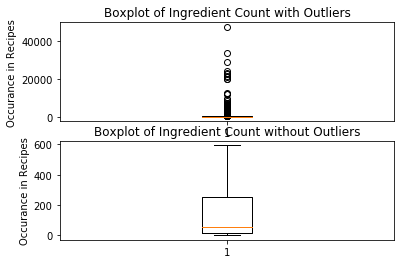

In [21]:
fig, axs = plt.subplots(2)
axs[0].boxplot(ingredient_counter["quantity"])
axs[0].set_title('Boxplot of Ingredient Count with Outliers')
axs[0].set_ylabel("Occurance in Recipes")

axs[1].boxplot(ingredient_counter["quantity"], 0, '')
axs[1].set_title('Boxplot of Ingredient Count without Outliers')
axs[1].set_ylabel("Occurance in Recipes")

plt.show

In [22]:
stop_ingredients = ['salt', 'sugar', 'flour', 'baking powder', 'baking soda', "cornstarch", 'nonstick cooking spray']

In [23]:
stop_ingredients

['salt',
 'sugar',
 'flour',
 'baking powder',
 'baking soda',
 'cornstarch',
 'nonstick cooking spray']

In [24]:
ingredient_counter = ingredient_counter.drop(stop_ingredients)
ingredient_counter.head()

,quantity
ingredient,
butter,33886
black pepper,23980
garlic,23054
olive oil,22736
eggs,21501


In [25]:
unique_list_of_recipe_puppy_ingredients = list(set(ingredient_list))

In [26]:
standarize_ingredient_dict = {}
for ing in unique_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
    if king_tup[1] >= 85:
        standarize_ingredient_dict[ing] = king_tup[0]

In [27]:
standarize_ingredient_dict

{'ham': 'ham',
 'egg': 'egg',
 'cheddar cheese': 'cheddar cheese',
 'eggplant': 'eggplant',
 'tangerine': 'tangerine',
 'horseradish': 'horseradish',
 'dill': 'dill',
 'oyster mushroom': 'oyster mushroom',
 'chanterelles': 'chanterelle',
 'avocado': 'avocado',
 'feta cheese': 'feta cheese',
 'bean sauce': 'soybean sauce',
 'capers': 'capers',
 'gruyere cheese': 'gruyere cheese',
 'applesauce': 'apple sauce',
 'crab': 'crab',
 'cardamom': 'cardamom',
 'custard': 'mustard',
 'fenugreek': 'fenugreek',
 'butter': 'butter',
 'red rice': 'red rice',
 'chervil': 'chervil',
 'crawfish': 'crayfish',
 'flour': 'flour',
 'figs': 'fig',
 'persimmons': 'persimmon',
 'lemon': 'lemon',
 'plum': 'plum',
 'wasabi': 'wasabi',
 'oats': 'oats',
 'yam': 'yam',
 'broccolini': 'broccoli',
 'cheese': 'cheese',
 'kiwifruit': 'kiwifruit',
 'cherry': 'cherry',
 'semolina': 'semolina',
 'provolone cheese': 'provolone cheese',
 'pumpkin': 'pumpkin',
 'goat cheese': 'goat cheese',
 'tofu': 'tofu',
 'lettuce': 'lett

In [28]:
standarize_ingredient_dict_rest = {}
for ing in unique_list_of_recipe_puppy_ingredients:
    king_tup = [ing, 0]
    for ing_2 in searched_ingredient_list:
        fuzz_ratio = fuzz.ratio(ing, ing_2)
        if  fuzz_ratio > king_tup[1]:
            king_tup = [ing_2, fuzz_ratio]
        standarize_ingredient_dict_rest[ing] = (king_tup[0], king_tup[1])

In [29]:
standarize_ingredient_dict_rest

{'granny smith apple': ('cashew apple', 60),
 'italian cheese blend': ('tilsit cheese', 61),
 'dried fruit': ('breadfruit', 76),
 'coriander seed': ('coriander', 78),
 'beef rib': ('beef', 67),
 'turkey sausage': ('turkey berry', 62),
 'julienne': ('quince', 57),
 'ham': ('ham', 100),
 'blueberry pie filling': ('blueberry', 60),
 'peas': ('pecans', 80),
 'ground mace': ('groundcherry', 70),
 'tuna': ('tinda', 67),
 'egg': ('egg', 100),
 'chicken soup': ('chicken', 74),
 'saltine crackers': ('atlantic croaker', 69),
 'pasta dough': ('sourdough', 60),
 'browning sauce': ('soybean sauce', 59),
 'pesto': ('pheasant', 62),
 'agave syrup': ('orange roughy', 50),
 'butter beans': ('butter', 67),
 'bow tie pasta': ('roibos tea', 52),
 'lowfat milk': ('goat milk', 80),
 'sweet milk': ('sheep milk', 80),
 'chicken giblets': ('chicken', 64),
 'cheddar cheese': ('cheddar cheese', 100),
 'pasilla chili powder': ('milk powder', 58),
 'raspberry preserves': ('raspberry', 64),
 'eggplant': ('eggplant'

In [30]:
def cleaner(row):
    ingredient_list = row["recipe_ingredients"]
    ingredient_list = [standarize_ingredient_dict[ing] for ing in ingredient_list if ing in standarize_ingredient_dict and ing not in ["garlic", "onion"]]
    return ingredient_list

In [31]:
recipe_puppy_api["recipe_ingredients"] = recipe_puppy_api.apply(lambda row: cleaner(row), axis=1)

In [32]:
recipe_puppy_api.head(100)

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
0,5caa762213218a112b0b979f,"[egg, mushroom, shallot, white pepper]",http://www.grouprecipes.com/31653/egg-noodles-...,Egg Noodles With Wonton Egg And Veggie Recipe,egg
1,5caa762213218a112b0b97a0,[egg],http://www.recipezaar.com/Egg-Peeling-for-Egg-...,Egg Peeling for Egg Salad,egg
2,5caa762213218a112b0b97a1,"[celery, cucumber, red currant, egg, ginger, l...",http://www.recipezaar.com/Curried-Egg-Salad-on...,Curried Egg Salad on a Bed of Greens -- an Egg...,egg
3,5caa762213218a112b0b97a2,"[butter, egg]",http://www.recipezaar.com/Ramen-Noodle-Egg-Foo...,Ramen Noodle Egg Foo Yung,egg
4,5caa762213218a112b0b97a3,"[cheese, egg]",http://www.recipezaar.com/Bacon-and-Egg-Cups-1...,Bacon and Egg Cups,egg
5,5caa762213218a112b0b97a4,"[celery, egg]",http://www.recipezaar.com/Egg-Salad-Sandwich-D...,Egg Salad Sandwich (Diabetic),egg
6,5caa762213218a112b0b97a5,[egg],http://www.recipezaar.com/Joleans-Sick-Egg-Rec...,"Jolean's "" Sick Egg"" Recipe",egg
7,5caa762213218a112b0b97a6,[egg],http://www.recipezaar.com/Greaneyes-Chipotle-T...,Greaneyes Chipotle Tabasco Egg Sandwich,egg
8,5caa762213218a112b0b97a7,"[butter, egg, onion]",http://www.recipezaar.com/Dr-Kims-Egg-Roll-211044,Dr. Kim's Egg Roll,egg
9,5caa762213218a112b0b97a8,"[egg, milk]",http://www.recipezaar.com/Easy-Egg-Wraps-77991,Easy Egg Wraps,egg


# Making a Graph

In [33]:
sample_graph = recipe_puppy_api.sample(n=10, random_state=10)

In [34]:
recipe_graph = graph_based_on_shared_recipe_creator(recipe_puppy_api)

In [35]:
sample_graph

,_id,recipe_ingredients,recipe_link,recipe_name,searched_ingredient
122230,5caa83da13218a112b0d7515,"[celery, cream, egg, mustard, onion, potato, w...",http://www.recipezaar.com/Nans-Classic-Mustard...,Nan's Classic Mustard Potato Salad,potato
133391,5caa852c13218a112b0da0ae,[summer savory],http://www.epicurious.com/recipes/food/views/G...,Grilled Country Ribs with Summer Savory Mustar...,summer savory
125041,5caa842c13218a112b0d8010,"[eggplant, parsley]","http://www.cooks.com/rec/view/0,191,152178-251...",Eggplant And Tahini,eggplant
169299,5caa896a13218a112b0e2cf2,"[semolina, squid]",http://www.bbc.co.uk/food/recipes/database/cri...,Crispy squid with garlic mayonnaise,squid
25815,5caa78f813218a112b0bfc76,"[blue cheese, onion]",http://cookeatshare.com/recipes/blue-cheese-sa...,Blue Cheese Salad Dressing Recipe,blue cheese
66067,5caa7d8413218a112b0c99b2,[strawberry],http://cookeatshare.com/recipes/easy-strawberr...,Easy Strawberry Pie Recipe,strawberry
66054,5caa7d8413218a112b0c99a5,[strawberry],http://cookeatshare.com/recipes/ashleigh-s-whi...,Ashleigh's White Chocolate Strawberry\nShortca...,strawberry
117323,5caa834f13218a112b0d61ea,[cucumber],http://cookeatshare.com/recipes/thai-marinated...,Thai Marinated Braised Beef With\nCucumber Recipe,cucumber
131408,5caa84eb13218a112b0d98ef,"[butter, cashew nut, egg, flour]",http://allrecipes.com/Recipe/Toffee-Cashew-Bar...,Toffee Cashew Bars,cashew nut
118171,5caa836613218a112b0d653a,[cucumber],http://www.cdkitchen.com/recipes/recs/133/Cucu...,Cucumber-Dill Salad Recipe,cucumber


In [36]:
recipe_graph.nodes(data = True)

NodeDataView({'egg': {'ingredient_node': True, 'molecule_node': False, 'category': 'Animal Product', 'quantity': 15282}, 'mushroom': {'ingredient_node': True, 'molecule_node': False, 'category': 'Fungus', 'quantity': 2448}, 'white pepper': {'ingredient_node': True, 'molecule_node': False, 'category': 'Spice', 'quantity': 1631}, 'shallot': {'ingredient_node': True, 'molecule_node': False, 'category': 'Vegetable', 'quantity': 2531}, 'cucumber': {'ingredient_node': True, 'molecule_node': False, 'category': 'Gourd', 'quantity': 1602}, 'celery': {'ingredient_node': True, 'molecule_node': False, 'category': 'Spice', 'quantity': 4482}, 'red currant': {'ingredient_node': True, 'molecule_node': False, 'category': 'Fruit', 'quantity': 12}, 'lemon': {'ingredient_node': True, 'molecule_node': False, 'category': 'Fruit Citrus', 'quantity': 2476}, 'walnut': {'ingredient_node': True, 'molecule_node': False, 'category': 'Nut', 'quantity': 2674}, 'ginger': {'ingredient_node': True, 'molecule_node': Fal

In [37]:
recipe_graph.nodes()

NodeView(('egg', 'mushroom', 'white pepper', 'shallot', 'cucumber', 'celery', 'red currant', 'lemon', 'walnut', 'ginger', 'butter', 'cheese', 'onion', 'milk', 'basil', 'mint', 'parsley', 'chive', 'mustard', 'tomato', 'flour', 'nutmeg', 'cheddar cheese', 'cumin', 'cream cheese', 'parmesan cheese', 'cornbread', 'cottage cheese', 'ricotta cheese', 'evaporated milk', 'horseradish', 'rice', 'fish', 'wheat', 'jalapeno', 'water chestnut', 'coriander', 'chicken', 'lettuce', 'vinegar', 'ham', 'potato', 'black bear', 'shrimp', 'nuts', 'pineapple', 'cherry pepper', 'cocoa powder', 'buttermilk', 'avocado', 'radish', 'swiss cheese', 'honey', 'pecans', 'turmeric', 'tofu', 'carrot', 'banana', 'cabbage', 'broccoli', 'condensed milk', 'cinnamon', 'cream', 'cisco', 'pork', 'beef', 'pear', 'orange', 'mandarin orange', 'gruyere cheese', 'poppy seed', 'coconut', 'chocolate', 'spinach', 'corn', 'tarragon', 'apple', 'blue cheese', 'skimmed milk', 'currant', 'yogurt', 'heart of palm', 'mozzarella cheese', 'ka